In [136]:
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import random
import pandas as pd
import seaborn as sns
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, DataCollatorWithPadding


%matplotlib inline

In [174]:
from datasets import Dataset
from google.colab import drive
drive.mount('/content/drive')
raw_datasets = load_dataset('csv', data_files='/content/drive/My Drive/IPP-M2-DS/Deep with python/Project IMDB/Data/IMDB Dataset.csv')
raw_datasets["train"]= raw_datasets["train"].add_column("labels", pd.Series(raw_datasets["train"]["sentiment"]).map({'negative':0,'positive':1}).tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using custom data configuration default-8ae4b7f686e27f43
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/default-8ae4b7f686e27f43/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

In [175]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 50000
    })
})

In [162]:
raw_datasets=raw_datasets["train"].train_test_split(0.5)
raw_data_valid = raw_datasets["train"].train_test_split(0.2)
raw_datasets["train"]= raw_data_valid["train"]
raw_datasets["valid"]= raw_data_valid["test"]
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 25000
    })
    valid: Dataset({
        features: ['review', 'sentiment', 'labels'],
        num_rows: 5000
    })
})

In [165]:
tokenizer = tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased",model_max_length=64)
def tokenize_function(example):
    return tokenizer(example["review"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [166]:
tokenized_datasets = tokenized_datasets.remove_columns(["review","sentiment"])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [167]:
from torch.utils.data import DataLoader

batch_size=11
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["valid"], batch_size=batch_size, collate_fn=data_collator
)



In [168]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [169]:
from transformers import get_scheduler

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1819


In [170]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [171]:
import torch
torch.cuda.empty_cache()

In [172]:
def train(model):
  metric = load_metric("accuracy")
  model.train()
  total_loss = 0
  n_batches=0
  for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    total_loss += loss
    n_batches+=1

    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

  total_loss = total_loss / n_batches
  accuracy = metric.compute()["accuracy"]
  print('Train epoch {}: loss = {}, accuracy = {}'.format(epoch,total_loss,accuracy))

  return model

def evaluate(model):
  metric = load_metric("accuracy")
  model.eval()
  total_loss=0
  n_batches=0
  for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    loss = outputs.loss
    total_loss += loss
    n_batches+=1
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

  accuracy = metric.compute()["accuracy"]
  total_loss = total_loss / n_batches

  print('Eval epoch {}: loss = {}, accuracy = {}'.format(epoch,total_loss,accuracy))
  
  return model





In [146]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
  metric = load_metric("accuracy")
  for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      metric.add_batch(predictions=predictions, references=batch["labels"])

100%|██████████| 1819/1819 [02:06<00:00, 14.97it/s]

In [147]:
metric.compute()

{'accuracy': 0.67255}

In [173]:
from tqdm.auto import tqdm
num_epochs=2
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):

  model = train(model)
  model = evaluate(model)

  0%|          | 0/1819 [00:00<?, ?it/s]

Train epoch 0: loss = 0.4176494777202606, accuracy = 0.8004
Eval epoch 0: loss = 0.3342086374759674, accuracy = 0.8482


https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df


https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df

https://huggingface.co/docs/transformers/model_doc/xlnet

In [6]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


In [7]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/IPP-M2-DS/Deep with python/Project IMDB/Data/IMDB Dataset.csv')
index_train=random.sample(range(data.shape[0]),int(data.shape[0]*0.7))
index_test = list(set(range(data.shape[0]))-set(index_train))
train = data.loc[index_train]
test = data.loc[index_test]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
train.head()

,review,sentiment
3680,You sit there for a half an hour and watch a s...,positive
13590,Full Moon High (1981) 3 of 5 Dir: Larry Cohen ...,positive
36897,"First time I saw this great movie and Alyssa, ...",positive
31457,Friz Freleng's 'Snafuperman' is one of the les...,negative
42493,"Very slow, dull, enigmatic film. MAybe the kin...",negative


# Preprocessing

### Tokenizer

Because model work only with number we need to convert words into numbers. Our goals is to find the best representation of these words. Inside the tokenizer object. The text is split into tokens. A token corresponds to a word, a part of a word or a punctuation. Then the tokenizer will use its internal vocabulary and transform each word into ids. The tokenizer method will follow a set of rules to transform texts into tokens. These rules will depend on the type of tokenizer used. ## before a word is a convention to indicate that this token is not the beginning of a word. _ before a word means the word had a space before it. These are conventions found in all huggingface tokenizers. It is important to use the same mapping as the one used for training the model. There are also special tokens like CLS and SEP. CLS is the token that indicates the beginning of the sentence and SEP the end.




In [1]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased",model_max_length=100)

NameError: ignored

In [38]:
sequence=train["review"][0]
sequence

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [42]:
tokens = tokenizer.tokenize(sequence)
tokens[:10]

['▁One',
 '▁of',
 '▁the',
 '▁other',
 '▁reviewer',
 's',
 '▁has',
 '▁mentioned',
 '▁that',
 '▁after']

In [43]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids[:10]

[436, 20, 18, 86, 16010, 23, 51, 2911, 29, 99]

To get an idea of ​​the number of tokens per text. We can transform each document into tokens, count them and plot their distribution.


In [46]:
tokenized_length = list(map(lambda t: len(tokenizer.tokenize(t)), train["review"].values))

tokenized_length mean =  324.29785714285714
tokenized_length median =  241.0
tokenized_length quantile 75% =  395.0


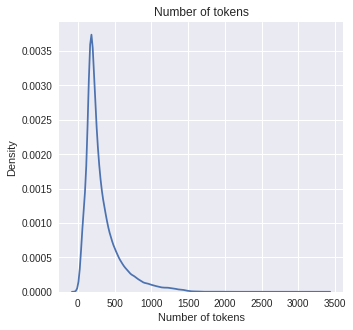

In [53]:
plt.style.use("seaborn")
g=sns.displot(tokenized_length,kind="kde")
plt.xlabel("Number of tokens")
plt.ylabel("Density")
plt.title('Number of tokens')
plt.subplots_adjust(bottom=0.15,top=0.9)

print('tokenized_length mean = ',np.mean(tokenized_length))
print('tokenized_length median = ',np.median(tokenized_length))
print('tokenized_length quantile 75% = ',np. quantile(tokenized_length, 0.75))


To obtain the same number of tokens for all the texts, I will take a quantile size of 75% and truncate or padd the sentences which are too large or too small.


In [9]:
embedding_size = 395

def text_to_ids(text,embedding_size):
  tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:embedding_size-2], text))
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  # append special token "<s>" and </s> to end of sentence
  input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
  # pad sequences
  input_ids = pad_sequences(input_ids, maxlen=embedding_size, dtype="long", truncating="post", padding="post")
  return input_ids

In [61]:
input_ids_train = text_to_ids(train["review"].values,embedding_size)
input_ids_test = text_to_ids(test["review"].values,embedding_size)

In [65]:
print(input_ids_train.shape)
input_ids_train

(35000, 395)


array([[  201,  2558,   105, ...,    18,     4,     3],
       [ 6761,  6878,  1254, ...,     0,     0,     0],
       [ 1300,    92,    35, ...,     0,     0,     0],
       ...,
       [ 3005,   111,  1853, ...,     0,     0,     0],
       [ 1583,    61,   175, ...,    19,     4,     3],
       [31602,  7417,  2266, ...,     0,     0,     0]])

Another important element for fintuning is the attention mask. These vectors let the model know which part has been padded. For this we give the value of 1 to the tokens and 0 to the elements that we have padded.


In [10]:
def attention_mask(input_ids):
  """ """
  attention_masks = []
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)
  return attention_masks

In [66]:



attention_mask_train = attention_mask(input_ids_train)
attention_mask_test = attention_mask(input_ids_test)

In [70]:
print(len(attention_mask_train))
print(len(attention_mask_train[9]))
attention_mask_train[9][:10]

35000
395


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [73]:
train["features"] = input_ids_train.tolist()
train["masks"] = attention_mask_train
test["features"] = input_ids_test.tolist()
test["masks"] = attention_mask_test

In [74]:
train.head()

,review,sentiment,features,masks
3680,You sit there for a half an hour and watch a s...,positive,"[201, 2558, 105, 28, 24, 455, 48, 1671, 21, 16...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13590,Full Moon High (1981) 3 of 5 Dir: Larry Cohen ...,positive,"[6761, 6878, 1254, 17, 10, 25204, 11, 198, 20,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
36897,"First time I saw this great movie and Alyssa, ...",positive,"[1300, 92, 35, 685, 52, 312, 1432, 21, 79, 111...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
31457,Friz Freleng's 'Snafuperman' is one of the les...,negative,"[7130, 553, 12009, 4693, 299, 26, 23, 17, 26, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
42493,"Very slow, dull, enigmatic film. MAybe the kin...",negative,"[8479, 2208, 19, 12692, 19, 31397, 468, 9, 772...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


we will also create a validation set which fears 20% of the size of the train set. 


In [11]:
index_train2=random.sample(index_train,int(len(index_train)*0.8))
index_valid = list(set(index_train)-set(index_train2))

print(len(index_valid),len(index_train2),len(index_test),7000+28000+15000)

7000 28000 15000 50000


We will keep 30% of the dataset for the end test and train our model on 70% of the data. With on these 70% 20% for the validation sample and 80% on the training sample. I thus create X_train X_valid which correspond to the ids. But also Y_train Y_valide which are the target variable in numerical format. But also mask tokens.



In [38]:
X_train = text_to_ids(data.loc[index_train2,"review"].values,embedding_size)
X_valid = text_to_ids(data.loc[index_valid,"review"].values,embedding_size)

train_masks = attention_mask(X_train)
valid_masks = attention_mask(X_valid)

Y_train = data.loc[index_train2,"sentiment"].map({"negative":0,"positive":1}).values
Y_valid= data.loc[index_valid,"sentiment"].map({"negative":0,"positive":1}).values

In [88]:
data.loc[index_train2,"sentiment"].value_counts()/data.loc[index_train2,"sentiment"].shape[0]

positive    0.500321
negative    0.499679
Name: sentiment, dtype: float64

In [39]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32).reshape(-1,1)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32).reshape(-1,1)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

Creation of the data loader


In [40]:
batch_size = 32

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [16]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state

# len(Y_train[0]) = 6
model = XLNetForMultiLabelSequenceClassification(num_labels=2)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
device="cpu"

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [41]:

for i in trange(num_epochs, desc="Epoch"):
  model.train()
  tr_loss = 0
  num_train_samples = 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    print(step)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    print(b_input_ids.shape, b_input_mask.shape, b_labels.shape)

    break
  break

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

0
torch.Size([32, 395]) torch.Size([32, 395]) torch.Size([32, 1])


In [ ]:
model(b_input_ids, b_input_mask, b_labels)

In [27]:
num_epochs=1
for i in trange(num_epochs, desc="Epoch"):
  model.train()
  tr_loss = 0
  num_train_samples = 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    print(step)
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    # store train loss
    tr_loss += loss.item()
    num_train_samples += b_labels.size(0)
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    #scheduler.step()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

0


Epoch:   0%|          | 0/1 [00:41<?, ?it/s]


ValueError: ignored

In [102]:

def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,
          train_loss_set=[], valid_loss_set = [], start_epoch=0,
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

  

  return model, train_loss_set, valid_loss_set




In [ ]:
train(model,2,optimizer,train_dataloader, validation_dataloader)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]